In [1]:
MODEL_SAVE_PATH = "/users/skoka/Documents/GAN-Lab/models"

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import sys
import tensorflow.keras
import scipy as sp
import tensorflow as tf
import platform
import numpy as np
import matplotlib.pyplot as plt
import random


import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML\

# watermark the notebook


print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")

gpus = tf.config.list_physical_devices('GPU')
print("GPU Resources Available:\n\t",gpus)

# getting rid of the warning messages about optimizer graph
# import logging
# logging.getLogger('tensorflow').setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)


# Seed control, for better reproducibility 
# NOTE: this does not gurantee results are always the same
seed = 22
random.seed(seed)
np.random.seed(seed)



EPOCHS = 100


Python Platform: Linux-5.4.0-109-generic-x86_64-with-glibc2.29
Tensor Flow Version: 2.11.0
Keras Version: 2.11.0

Python 3.8.10 (default, Mar 15 2022, 12:22:08) 
[GCC 9.4.0]
GPU Resources Available:
	 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def make_grid(img_batches):
    batch = img_batches.shape[0]
    n_elem = round(np.sqrt(batch))
    i = 0
    j = 0
    size =  img_batches.shape[1]
    grid = np.zeros((n_elem*size,n_elem*size,3))
    for chan in range(batch):
        im = img_batches[chan,:,:,:]
        grid[i*size:(i+1)*size,j*size:(j+1)*size,:] = im.reshape((size,size,3))
        i += 1
        if i >= n_elem:
            i = 0
            j += 1
            if j >= n_elem:
                break # we are at the end of the grid capacity
    return grid

BATCH_SIZE = 256 # might try to use large batches (we will discuss why later when we talk about BigGAN)
# NOTE: the batch_size should be an integer divisor of the data set size  or torch
# will give you an error regarding batch sizes of "0" when the data loader tries to
# load in the final batch

# setup GAN dataset
(train_images, train_labels), (_, _) = tf.keras.datasets.cifar10.load_data()
train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
train_labels = tf.keras.utils.to_categorical(train_labels, 10)

BUFFER_SIZE = 60000

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [4]:
from tensorflow.keras import layers
latent_dim = 100
image_size = 32
channels = 3
num_classes = 10


# this model originally from https://www.tensorflow.org/tutorials/generative/dcgan 
# manipulated to have different sizing possible
def make_generator_model():
    # assume we have a 100 dimensional sampling vector
    
    # First, transform the input into a 7x7 256-channels feature map, from latent space
    # latent space starts at 100, then upsamples for convolutio
    model = tf.keras.Sequential()
    int_size_4 = int(image_size/4)
    model.add(layers.Dense(int_size_4*int_size_4*256, use_bias=False, input_shape=(latent_dim + num_classes,), name="generator_dense_1"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # reshape to imaging for convolution
    
    model.add(layers.Reshape((int_size_4, int_size_4, 256)))
    assert model.output_shape == (None, int_size_4, int_size_4, 256)  # Note: None is the batch size

    # we will use the sequential API
    # in order to create some blocks
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, int_size_4, int_size_4, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    int_size_2 = int(image_size/2)
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, int_size_2, int_size_2, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(channels, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, image_size, image_size, channels)

    return model

In [5]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[image_size, image_size, channels + num_classes], name="discriminator_conv_1"))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [6]:
# Define the output as normal GAN
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # binary cross entropy 

def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss # minimize (slides have max in them)


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img) # minimize (slides have max in them)

In [7]:
        
# Is AdaM good here? Would that improve performance? :) 
# Decay rate adjustment? 
# set discriminator learning higher than generator?
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
lambda_gp = 10

In [8]:
# This code was taken from https://keras.io/examples/generative/conditional_gan/#creating-a-conditionalgan-model
class ConditionalGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")


    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
  
    def save_models(self, folder_name):
        self.generator.save(folder_name + "/generator")
        self.discriminator.save(folder_name + "/discriminator")
        
    def load_models(self, folder_name):
        self.generator = tf.keras.models.load_model(folder_name + "/generator")
        self.discriminator = tf.keras.models.load_model(folder_name + "/discriminator")


    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = tf.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = tf.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )
        for i in range(3): # train discriminator 3 times for every generator train

            # Sample random points in the latent space and concatenate the labels.
            # This is for the generator.
            batch_size = tf.shape(real_images)[0]
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            random_vector_labels = tf.concat(
                [random_latent_vectors, one_hot_labels], axis=1
            )
            with tf.GradientTape() as disc_tape:
                # Decode the noise (guided by labels) to fake images.
                generated_images = self.generator(random_vector_labels, training=True)


                # Combine them with real images. Note that we are concatenating the labels
                # with these images here.
                fake_image_and_labels = tf.concat([generated_images, image_one_hot_labels], -1)
                real_image_and_labels = tf.concat([real_images, image_one_hot_labels], -1)
                combined_images = tf.concat(
                    [fake_image_and_labels, real_image_and_labels], axis=0
                )
                # also get interpolations for the gradient penalty
                alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
                diff = generated_images - real_images
                interpolated = real_images + alpha * diff
                interpolated = tf.concat([interpolated, image_one_hot_labels], -1)

                # Assemble labels discriminating real from fake images.
                labels = tf.concat(
                    [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
                )
                fake_output = self.discriminator(fake_image_and_labels, training=True)
                real_output = self.discriminator(real_image_and_labels, training=True)
                disc_loss = discriminator_loss(real_output, fake_output)


                with tf.GradientTape(watch_accessed_variables=False) as gp_tape:
                    gp_tape.watch(interpolated)

                    interpolated_output = self.discriminator(interpolated, training=True)
                grads = gp_tape.gradient(interpolated_output, interpolated)
                norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
                gp = tf.reduce_mean((norm - 1.0) ** 2)
                d_loss = disc_loss + lambda_gp * gp
            gradients_of_discriminator = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))


        # Sample random points in the latent space.
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_vector_labels = tf.concat(
            [random_latent_vectors, one_hot_labels], axis=1
        )


        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as gen_tape:
            fake_images = self.generator(random_vector_labels, training=True)
            fake_image_and_labels = tf.concat([fake_images, image_one_hot_labels], -1)
            
            predictions = self.discriminator(fake_image_and_labels, training=True)
            
            g_loss = generator_loss(predictions)
        
        


        grads = gen_tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }



In [9]:
discriminator = make_discriminator_model()
generator = make_generator_model()
cond_gan = ConditionalGAN(discriminator, generator, latent_dim)



In [10]:
cond_gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=discriminator_loss
)

In [11]:
cond_gan.d_optimizer.build(cond_gan.discriminator.trainable_variables)
cond_gan.g_optimizer.build(cond_gan.generator.trainable_variables)

In [12]:
cond_gan.load_models("/users/skoka/Documents/GAN-Lab/BaseGAN")

In [13]:
# We first extract the trained generator from our Conditiona GAN.
trained_gen = cond_gan.generator

# Choose the number of intermediate images that would be generated in
# between the interpolation + 2 (start and last images).
num_interpolation = 9  # @param {type:"integer"}

# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = tf.keras.utils.to_categorical([first_number], num_classes)
    second_label = tf.keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)

    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return fake


start_class = 8  # @param {type:"slider", min:0, max:9, step:1}
end_class = 8  # @param {type:"slider", min:0, max:9, step:1}

fake_images = interpolate_class(start_class, end_class)
fake_images = (fake_images * 127.5) + 127.5

1/1 [==============================] - 5s 5s/step


1/1 [==============================] - 0s 39ms/step


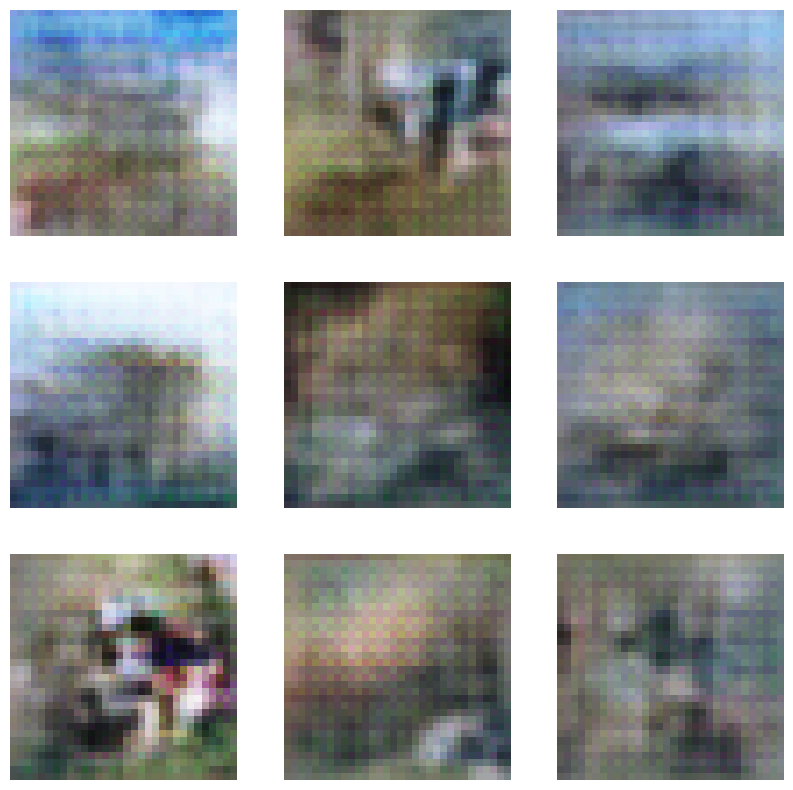

In [14]:
# plot 10 images from new cond gan at class 8:

CLASS_TO_GEN = 8

noise = tf.random.normal(shape=(1, latent_dim))
noise = tf.repeat(noise, repeats=9)
noise = tf.reshape(noise, (9, latent_dim))

# generate a one hot vector for the class
labels = tf.one_hot([CLASS_TO_GEN] * 9, depth=10)
labels = tf.reshape(labels, (9, 10))
noise_and_labels = tf.concat([noise, labels], 1)

generated_images = cond_gan.generator.predict(noise_and_labels)
generated_images = (generated_images * 127.5) + 127.5



# plot the result

fig = plt.figure(figsize=(10, 10))

for i in range(generated_images.shape[0]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(generated_images[i].astype("int32"))
    plt.axis("off")


In [15]:
# Fine tune VGG 19 to classify MNIST

VGG = tf.keras.applications.VGG19(
    include_top=False, weights='imagenet', input_shape=(image_size, image_size, channels)
)

# for layer in VGG.layers[:-4]:
#     layer.trainable = False

# Create the model
VGG_model = tf.keras.Sequential()
VGG_model.add(VGG)
VGG_model.add(layers.Flatten())
VGG_model.add(layers.Dense(10, activation='softmax'))

VGG_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

VGG_model.summary()

# split training_dataset into train and validation
# train_labels and train_images
# Train: 40000
# Validation: 10000

from sklearn.model_selection import train_test_split
vgg_train_images, vgg_validation_images, vgg_train_labels, vgg_validation_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# history = VGG_model.fit(vgg_train_images, vgg_train_labels, epochs=25, batch_size=1024, validation_data=(vgg_validation_images, vgg_validation_labels))

# VGG_model.save("/users/skoka/Documents/GAN-Lab/VGG_model.h5")

VGG_model = tf.keras.models.load_model("/users/skoka/Documents/GAN-Lab/VGG_model.h5")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 20,029,514
Trainable params: 20,029,514
Non-trainable params: 0
_________________________________________________________________


In [16]:
# plot history:
# plt.plot(history.history['loss'], label='accuracy')
# plt.plot(history.history['val_loss'], label='val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')

In [56]:
# Get inception score with the trained VGG model
import scipy
def get_inception_score(images, labels, splits=10):
    # get average output for vgg 
    output = VGG_model.predict(images)
    mean_output = np.mean(output, axis=0)
    # use KL divergence between mean output and each output
    kl_divergence_sum = 0
    for i in range(output.shape[0]):
        kl_divergence_sum += scipy.stats.entropy(output[i], qk=mean_output)
    
    # get inception score
    inception_score = np.exp(kl_divergence_sum / output.shape[0])
    return inception_score

    

In [79]:
# Generate 1000 images from each of the ten classes of the trained generator
trained_gen = cond_gan.generator
noise = tf.random.normal(shape=(1, latent_dim))
noise = tf.repeat(noise, repeats=10000)
noise = tf.reshape(noise, (10000, latent_dim))


# generate a one hot vector for the class
labels = tf.one_hot([0,1,2,3,4,5,6,7,8,9] * 1000, depth=10)
labels = tf.reshape(labels, (10000, 10))

noise_and_labels = tf.concat([noise, labels], 1)

generated_images = trained_gen.predict(noise_and_labels)
generated_images = (generated_images * 127.5) + 127.5

# get inception score
cond_gan_inception_score = get_inception_score(generated_images, labels)
print(cond_gan_inception_score)


313/313 [==============================] - 1s 4ms/step
4.107443919584137


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


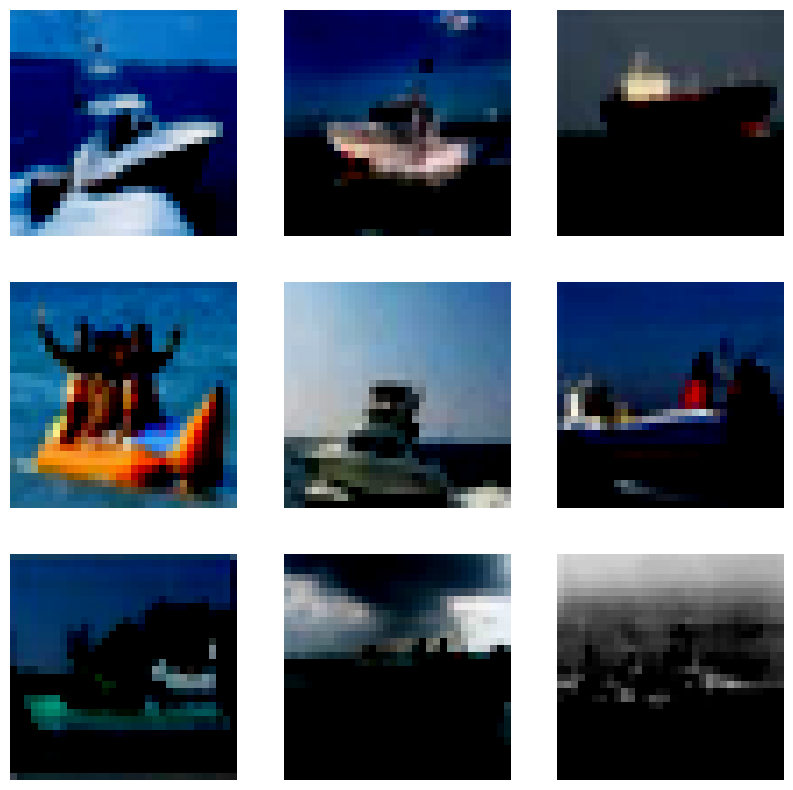

In [18]:
# plot 10 real images of class 9
plt.figure(figsize=(10, 10))
new_train_labels = np.argmax(train_labels, axis=1)
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[new_train_labels == 8][i])
    plt.axis("off")

In [19]:
import tensorflow as tf


class ClassConditionalBatchNormalization(layers.Layer):
  def __init__(self, num_categories, decay_rate=0.999, 
               center=True, scale=True):
    super(ClassConditionalBatchNormalization, self).__init__()
    self.num_categories = num_categories
    self.center = center
    self.scale = scale
    self.decay_rate = decay_rate
    
  def build(self, input_size):
    self.inputs_shape = tf.TensorShape(input_size)
    params_shape = self.inputs_shape[-1:]
    axis = [0, 1, 2]
    shape = tf.TensorShape([self.num_categories]).concatenate(params_shape)
    moving_shape = tf.TensorShape([1,1,1]).concatenate(params_shape)
    
    self.gamma = self.add_weight(name='gamma', shape=shape,
                                   initializer='ones')
    self.beta  = self.add_weight(name='beta', shape=shape,
                                   initializer='zeros')
    
    self.moving_mean = self.add_weight(name='mean',
                                         shape=moving_shape,
                                         initializer='zeros',
                                         trainable=False)
    self.moving_var  = self.add_weight(name='var',
                                         shape=moving_shape,
                                         initializer='ones', 
                                         trainable=False)
    
    
  def call(self, inputs, labels, is_training=True):
    beta = tf.gather(self.beta, labels)
    beta = tf.expand_dims(tf.expand_dims(beta, 1), 1)
    gamma = tf.gather(self.gamma, labels)
    gamma = tf.expand_dims(tf.expand_dims(gamma, 1), 1)
    decay = self.decay_rate
    variance_epsilon = 1e-5
    axis = [0, 1, 2]
    if is_training:
      mean, variance = tf.nn.moments(inputs, axis, keepdims=True)
      self.moving_mean.assign(self.moving_mean * decay + mean * (1 - decay))
      self.moving_var.assign(self.moving_var * decay + variance * (1 - decay))
      outputs = tf.nn.batch_normalization(
          inputs, mean, variance, beta, gamma, variance_epsilon)
    else:
      outputs = tf.nn.batch_normalization(
          inputs, self.moving_mean, self.moving_var, 
          beta, gamma, variance_epsilon)
    outputs.set_shape(self.inputs_shape)
    return outputs


# this model originally from https://www.tensorflow.org/tutorials/generative/dcgan
# manipulated to have different sizing possible
class Generato_WithEmbeddings(tf.keras.Model):
    def __init__(self, num_classes):
        super(Generato_WithEmbeddings, self).__init__()
        self.num_classes = num_classes

        self.dense = tf.keras.layers.Dense(
            8 * 8 * 256, use_bias=False, name='dense', input_shape=(latent_dim,))
        # self.bn1 = ClassConditionalBatchNormalization(num_classes)
        self.relu1 = tf.keras.layers.ReLU()

        self.conv1 = tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(
            1, 1), padding='same', use_bias=False, name='conv1')
        self.bn2 = ClassConditionalBatchNormalization(num_classes)
        self.relu2 = tf.keras.layers.ReLU()

        self.conv2 = tf.keras.layers.Conv2DTranspose(
            64, (5, 5), strides=(2, 2), padding='same', use_bias=False)
        self.bn3 = ClassConditionalBatchNormalization(num_classes)
        self.relu3 = tf.keras.layers.ReLU()

        self.conv3 = tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(
            2, 2), padding='same', use_bias=False, activation='tanh')

    def call(self, noise, class_index, training=True):

        # noise, class_index = inputs

        # Get class-specific gamma and beta from embedding
        # gamma = tf.gather(self.bn1.gamma, class_index)
        # beta = tf.gather(self.bn1.beta, class_index)
        x = self.dense(noise)
        x = self.relu1(x)

        x = tf.reshape(x, [-1, 8, 8, 256])

        # Get class-specific gamma and beta from embedding
        # gamma = tf.gather(self.bn2.gamma, class_index)
        # beta = tf.gather(self.bn2.beta, class_index)

        x = self.conv1(x)
        x = self.bn2(x, class_index, training=training)
        x = self.relu2(x)

        # Get class-specific gamma and beta from embedding
        # gamma = tf.gather(self.bn3.gamma, class_index)
        # beta = tf.gather(self.bn3.beta, class_index)

        x = self.conv2(x)
        x = self.bn3(x, class_index, training=training)
        x = self.relu3(x)

        x = self.conv3(x)

        return x


class Discriminator_WithEmbeddings(tf.keras.Model):
    def __init__(self, num_classes):
        super(Discriminator_WithEmbeddings, self).__init__()
        self.num_classes = num_classes

        self.conv1 = tf.keras.layers.Conv2D(
            64, (5, 5), strides=(2, 2), padding='same')
        self.leaky_relu1 = tf.keras.layers.LeakyReLU()
        self.bn1 = ClassConditionalBatchNormalization(num_classes)

        self.conv2 = tf.keras.layers.Conv2D(
            128, (5, 5), strides=(2, 2), padding='same')
        self.leaky_relu2 = tf.keras.layers.LeakyReLU()
        self.bn2 = ClassConditionalBatchNormalization(num_classes)

        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(1)

    def call(self, inputs, class_index, training=None):

        # Get class-specific gamma and beta from embedding
        # gamma = tf.gather(self.bn1.gamma, class_index)
        # beta = tf.gather(self.bn1.beta, class_index)

        x = self.conv1(inputs)
        x = self.leaky_relu1(x)
        x = self.bn1(x, class_index, training=training)

        # Get class-specific gamma and beta from embedding
        # gamma = tf.gather(self.bn2.gamma, class_index)
        # beta = tf.gather(self.bn2.beta, class_index)

        x = self.conv2(x)
        x = self.leaky_relu2(x)
        x = self.bn2(x, class_index, training=training)

        x = self.flatten(x)
        x = self.dense(x)

        return x


# This code was taken from https://keras.io/examples/generative/conditional_gan/#creating-a-conditionalgan-model
class ConditionalGAN_ClassEmbeddings(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(
            name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

        # self.d_optimizer.build(self.discriminator.trainable_variables)
        # self.g_optimizer.build(self.generator.trainable_variables)
    def save_models(self, folder_name):
        self.generator.save(folder_name + "/generator")
        self.discriminator.save(folder_name + "/discriminator")
        
    def load_models(self, folder_name):
        self.generator = tf.keras.models.load_model(folder_name + "/generator")
        self.discriminator = tf.keras.models.load_model(folder_name + "/discriminator")

    @tf.function
    def train_step(self, data):
        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        images, labels = data
        batch_size = tf.shape(images)[0]

        for i in range(3):

            # Get the latent vector
            noise = tf.random.normal([batch_size, latent_dim])

            with tf.GradientTape() as disc_tape:

                # Generate fake images from the latent vector
                generated_images = self.generator(noise, labels, training=True)

                # also get interpolations for the gradient penalty
                alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
                diff = generated_images - images
                interpolated = images + alpha * diff

                # Get the logits for the fake images
                fake_output = self.discriminator(generated_images, labels, training=True)

                # Get the logits for the real images
                real_output = self.discriminator(images, labels, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                disc_loss = discriminator_loss(real_output,fake_output)

                # code from https://keras.io/examples/generative/wgan_gp/
                # Calculate the gradient penalty
                with tf.GradientTape(watch_accessed_variables=False) as gp_tape:
                    gp_tape.watch(interpolated) # manually define what to watch
                    # 1. Get the discriminator output for this interpolated image.
                    pred = self.discriminator(interpolated, labels, training=True)

                # Calculate the gradients w.r.t to this interpolated image.
                grads = gp_tape.gradient(pred, [interpolated])[0]

                # Calculate the norm of the gradients.
                norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
                gp = tf.reduce_mean((norm - 1.0) ** 2) # is norm close to 1?


                # Add the gradient penalty to the original discriminator loss
                d_loss = disc_loss + gp * lambda_gp

            # Get the gradients w.r.t the discriminator loss
            gradients_of_discriminator = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        

        # Train the generator
        # Get the latent vector
        noise = tf.random.normal([batch_size, latent_dim])
        with tf.GradientTape() as gen_tape:

            # Generate fake images using the generator
            generated_images = self.generator(noise, labels, training=True)
            # Get the discriminator logits for fake images
            fake_output = self.discriminator(generated_images, labels, training=True)

            # Calculate the generator loss
            gen_loss = generator_loss(fake_output)


        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

        self.gen_loss_tracker.update_state(gen_loss)
        self.disc_loss_tracker.update_state(d_loss)

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }


In [20]:
new_descriminator = Discriminator_WithEmbeddings(num_classes)
new_generator = Generato_WithEmbeddings(num_classes)

# Compile the WGAN model.
new_cond_gan = ConditionalGAN_ClassEmbeddings(
    discriminator=new_descriminator, generator=new_generator, latent_dim=latent_dim
)
new_cond_gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=discriminator_loss
)

# Create a new training_dataset with labels that are label encoded instead of one-hot encoded
new_train_labels = np.argmax(train_labels, axis=1)


new_cond_gan.load_models("/users/skoka/Documents/GAN-Lab/ClassEmbeddingsGan")


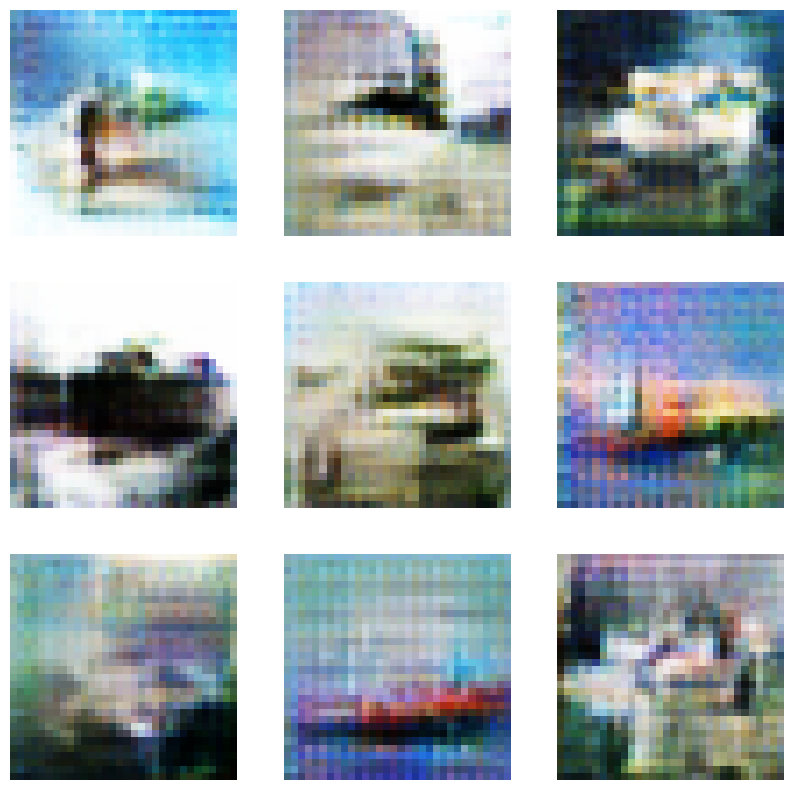

In [81]:
# plot 10 images from new cond gan at class 8:

CLASS_TO_GEN = 8

noise = tf.random.normal([9, latent_dim])

# generate images
# Create a numpy vector where all the values are 8
array = [CLASS_TO_GEN] * 9
# Convert the array to a numpy array
class_labels = np.array(array)

generated_images = new_cond_gan.generator.call(noise, class_labels, training=False)
generated_images = (generated_images * 127.5) + 127.5

# plot the result

fig = plt.figure(figsize=(10, 10))

for i in range(generated_images.shape[0]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(generated_images[i].numpy().astype("int32"))
    plt.axis("off")

In [76]:
# Generate 1000 images from each of the ten classes of the trained generator
trained_gen = new_cond_gan.generator
noise = tf.random.normal(shape=(1, latent_dim))
noise = tf.repeat(noise, repeats=10000)
noise = tf.reshape(noise, (10000, latent_dim))


# generate a one hot vector for the class
labels = tf.one_hot([0,1,2,3,4,5,6,7,8,9] * 1000, depth=10)
labels = tf.reshape(labels, (10000, 10))

# np arg max to get the class
labels = np.argmax(labels, axis=1)


generated_images = trained_gen.call(noise, labels, training=False)
generated_images = (generated_images * 127.5) + 127.5

# get inception score
new_cond_gan_inception_score = get_inception_score(generated_images, labels)
print(new_cond_gan_inception_score)


313/313 [==============================] - 1s 4ms/step
4.477727988257612


In [22]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, Embedding, Concatenate, Input
class GANAttention(tf.keras.Model):
    def __init__(self):
        super(GANAttention, self).__init__()

    def build(self, input_shape):
        # add gamma as a trainable variable
        self.gamma = self.add_weight(name="gamma", shape=[1], initializer=tf.initializers.zeros)
        _, height, width, channels = input_shape
        self.channels = channels
        self.height = height
        self.width = width
        self.map_size = height * width
        key_query_filters = self.channels // 8
        self.Key = Conv2D(key_query_filters, kernel_size=[1, 1], padding='same')
        self.Query = Conv2D(key_query_filters, kernel_size=[1, 1], padding='same')
        self.Value = Conv2D(self.channels, kernel_size=[1, 1], padding='same')

    def call(self, x):
        batch_size = tf.shape(x)[0]  # Get the dynamic batch size
        Query = self.Query(x)
        Key = self.Key(x)
        Value = self.Value(x)
        Query = tf.reshape(Query, [batch_size, self.map_size, self.channels // 8])
        Key = tf.reshape(Key, [batch_size, self.channels // 8, self.map_size])
        Value = tf.reshape(Value, [batch_size, self.channels, self.map_size])
        Attention = tf.matmul(Query, Key)

        Attention = tf.nn.softmax(Attention, axis=-1)
        Attention = tf.reshape(Attention, [batch_size, self.map_size, self.map_size])
        Attention = tf.matmul(Value, Attention)
        Attention = tf.reshape(Attention, [batch_size, self.height, self.width, self.channels])
        return self.gamma * Attention + x


In [27]:
class Generator_With_Attention(tf.keras.Model):
    def __init__(self, num_classes):
        super(Generator_With_Attention, self).__init__()
        self.num_classes = num_classes

        self.dense = tf.keras.layers.Dense(
            8 * 8 * 256, use_bias=False, name='dense', input_shape=(latent_dim,))
        # self.bn1 = ClassConditionalBatchNormalization(num_classes)
        self.relu1 = tf.keras.layers.LeakyReLU()

        self.conv1 = tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(
            1, 1), padding='same', use_bias=False, name='conv1')
        self.bn2 = ClassConditionalBatchNormalization(num_classes)
        self.relu2 = tf.keras.layers.LeakyReLU()

        self.conv2 = tf.keras.layers.Conv2DTranspose(
            64, (5, 5), strides=(2, 2), padding='same', use_bias=False)
        self.bn3 = ClassConditionalBatchNormalization(num_classes)
        self.relu3 = tf.keras.layers.LeakyReLU()

        self.attention = GANAttention()

        self.conv3 = tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(
            2, 2), padding='same', use_bias=False, activation='tanh')

    def call(self, noise, class_index, training=True):

        # noise, class_index = inputs

        # Get class-specific gamma and beta from embedding
        # gamma = tf.gather(self.bn1.gamma, class_index)
        # beta = tf.gather(self.bn1.beta, class_index)
        x = self.dense(noise)
        x = self.relu1(x)

        x = tf.reshape(x, [-1, 8, 8, 256])

        # Get class-specific gamma and beta from embedding
        # gamma = tf.gather(self.bn2.gamma, class_index)
        # beta = tf.gather(self.bn2.beta, class_index)

        x = self.conv1(x)
        x = self.bn2(x, class_index, training=training)
        x = self.relu2(x)

        # Get class-specific gamma and beta from embedding
        # gamma = tf.gather(self.bn3.gamma, class_index)
        # beta = tf.gather(self.bn3.beta, class_index)

        x = self.conv2(x)
        x = self.bn3(x, class_index, training=training)
        x = self.relu3(x)

        x = self.attention(x)

        x = self.conv3(x)

        return x


class Discriminator_With_Attention(tf.keras.Model):
    def __init__(self, num_classes):
        super(Discriminator_With_Attention, self).__init__()
        self.num_classes = num_classes

        self.conv1 = tf.keras.layers.Conv2D(
            64, (5, 5), strides=(2, 2), padding='same')
        self.leaky_relu1 = tf.keras.layers.LeakyReLU()
        self.bn1 = ClassConditionalBatchNormalization(num_classes)
        
        self.attention = GANAttention()
        self.conv2 = tf.keras.layers.Conv2D(
            128, (5, 5), strides=(2, 2), padding='same')
        self.leaky_relu2 = tf.keras.layers.LeakyReLU()
        self.bn2 = ClassConditionalBatchNormalization(num_classes)

        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(1)

    def call(self, inputs, class_index, training=None):

        # Get class-specific gamma and beta from embedding
        # gamma = tf.gather(self.bn1.gamma, class_index)
        # beta = tf.gather(self.bn1.beta, class_index)

        x = self.conv1(inputs)
        x = self.leaky_relu1(x)
        x = self.bn1(x, class_index, training=training)

        # Get class-specific gamma and beta from embedding
        # gamma = tf.gather(self.bn2.gamma, class_index)
        # beta = tf.gather(self.bn2.beta, class_index)

        x = self.attention(x)
        x = self.conv2(x)
        x = self.leaky_relu2(x)
        x = self.bn2(x, class_index, training=training)

        x = self.flatten(x)
        x = self.dense(x)

        return x


# This code was taken from https://keras.io/examples/generative/conditional_gan/#creating-a-conditionalgan-model
class ConditionalGAN_Attention(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(
            name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]
    
    def save_models(self, folder_name):
        self.generator.save(folder_name + "/generator")
        self.discriminator.save(folder_name + "/discriminator")
        
    def load_models(self, folder_name):
        self.generator = tf.keras.models.load_model(folder_name + "/generator")
        self.discriminator = tf.keras.models.load_model(folder_name + "/discriminator")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

        # self.d_optimizer.build(self.discriminator.trainable_variables)
        # self.g_optimizer.build(self.generator.trainable_variables)
    @tf.function
    def train_step(self, data):
        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 3 extra steps
        # as compared to 5 to reduce the training time.
        images, labels = data
        batch_size = tf.shape(images)[0]

        for i in range(3):

            # Get the latent vector
            noise = tf.random.normal([batch_size, latent_dim])

            with tf.GradientTape() as disc_tape:

                # Generate fake images from the latent vector
                generated_images = self.generator(noise, labels, training=True)

                # also get interpolations for the gradient penalty
                alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
                diff = generated_images - images
                interpolated = images + alpha * diff

                # Get the logits for the fake images
                fake_output = self.discriminator(generated_images, labels, training=True)

                # Get the logits for the real images
                real_output = self.discriminator(images, labels, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                disc_loss = self.loss_fn(real_output,fake_output)

                # code from https://keras.io/examples/generative/wgan_gp/
                # Calculate the gradient penalty
                with tf.GradientTape(watch_accessed_variables=False) as gp_tape:
                    gp_tape.watch(interpolated) # manually define what to watch
                    # 1. Get the discriminator output for this interpolated image.
                    pred = self.discriminator(interpolated, labels, training=True)

                # Calculate the gradients w.r.t to this interpolated image.
                grads = gp_tape.gradient(pred, [interpolated])[0]

                # Calculate the norm of the gradients.
                norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
                gp = tf.reduce_mean((norm - 1.0) ** 2) # is norm close to 1?


                # Add the gradient penalty to the original discriminator loss
                d_loss = disc_loss + gp * lambda_gp

            # Get the gradients w.r.t the discriminator loss
            gradients_of_discriminator = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        

        # Train the generator
        # Get the latent vector
        noise = tf.random.normal([batch_size, latent_dim])
        with tf.GradientTape() as gen_tape:

            # Generate fake images using the generator
            generated_images = self.generator(noise, labels, training=True)
            # Get the discriminator logits for fake images
            fake_output = self.discriminator(generated_images, labels, training=True)

            # Calculate the generator loss
            gen_loss = generator_loss(fake_output)


        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))

        self.gen_loss_tracker.update_state(gen_loss)
        self.disc_loss_tracker.update_state(d_loss)

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [76]:
Attn_Discriminator = Discriminator_With_Attention(num_classes=10)
Attn_Generator = Generator_With_Attention(num_classes=10)

# Compile the WGAN model.
attn_gan = ConditionalGAN_Attention(
    discriminator=Attn_Discriminator, generator=Attn_Generator, latent_dim=latent_dim
)
attn_gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=discriminator_loss
)

# Create a new training_dataset with labels that are label encoded instead of one-hot encoded
new_train_labels = np.argmax(train_labels, axis=1)


attn_gan.load_models("/users/skoka/Documents/GAN-Lab/AttentionGAN")

Epoch 1/10
196/196 [==============================] - 56s 97ms/step - g_loss: 11.1465 - d_loss: -11.7145
Epoch 2/10
196/196 [==============================] - 19s 95ms/step - g_loss: 18.3723 - d_loss: -21.7247
Epoch 3/10
 56/196 [=======>......................] - ETA: 13s - g_loss: 20.9282 - d_loss: -39.5938

KeyboardInterrupt: 

In [28]:
def discriminator_hinge_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss * real_loss # minimize (slides have max in them)


In [29]:
Attn_Discriminator = Discriminator_With_Attention(num_classes=10)
Attn_Generator = Generator_With_Attention(num_classes=10)

# Compile the WGAN model.
attn_gan_with_hinge = ConditionalGAN_Attention(
    discriminator=Attn_Discriminator, generator=Attn_Generator, latent_dim=latent_dim
)
attn_gan_with_hinge.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=discriminator_hinge_loss
)

# Create a new training_dataset with labels that are label encoded instead of one-hot encoded
new_train_labels = np.argmax(train_labels, axis=1)

for i in range(4):
    attn_gan_with_hinge.fit(train_images, new_train_labels, epochs=500, batch_size=256, verbose=2)



Epoch 1/500
196/196 [==============================] - 56s 96ms/step - g_loss: -501.5256 - d_loss: -371449.1058
Epoch 2/500
196/196 [==============================] - 19s 96ms/step - g_loss: -2751.3075 - d_loss: -7229064.2373
Epoch 3/500
 67/196 [=========>....................] - ETA: 12s - g_loss: -5088.3100 - d_loss: -24638362.2687

KeyboardInterrupt: 